In [1]:
import numpy as np 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.models import Model
import gym

In [2]:
a = np.array([0,1,2])
b = np.zeros((a.size, a.max()+1))
b[np.arange(a.size),a] = 1


In [3]:
from tensorflow.keras import layers

In [4]:
import pettingzoo
from pettingzoo.mpe import simple_spread_v1

In [5]:
env =simple_spread_v1.parallel_env(max_frames=100)


C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [6]:
num_states = env.observation_spaces['agent_0'].shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_spaces['agent_0'].shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_spaces['agent_0'].high[0]
lower_bound = env.action_spaces['agent_0'].low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  18
Size of Action Space ->  2
Max Value of Action ->  1.0
Min Value of Action ->  -1.0


In [7]:
num_states=21

In [8]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [9]:
std_dev = 0.10
ou_noise = OUActionNoise(mean=np.zeros(num_actions), std_deviation=float(std_dev) * np.ones(num_actions))

In [17]:
class Agent:
    def __init__(self, buffer_capacity=5, batch_size=3):
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size

        self.buffer_counter = 0
        self.last_states={'agent_0':0,'agent_1':0,'agent_2':0}
        
        self.next_states={'agent_0':0,'agent_1':0,'agent_2':0}
        
        self.state_buffer = np.zeros((self.buffer_capacity, 21))
        self.action_buffer = np.zeros((self.buffer_capacity, 2))
        self.next_state_buffer=np.zeros((self.buffer_capacity,21))
        self.reward_buffer=np.zeros((self.buffer_capacity,1))
        
        self.actor=get_actor()
        self.target_actor=get_actor()
        
        self.critic=get_critic()
        self.target_critic = get_critic()
        
        self.target_critic.set_weights(self.critic.get_weights())
        self.target_actor.set_weights(self.actor.get_weights())
        
        self.critic_lr = 0.0003
        self.actor_lr = 0.0003
        self.gamma=0.99
        self.tau=0.005
        self.epsilon=1
        self.episode_steps=0
        self.sum_rewards = []
        self.upper_bound=1
        self.lower_bound=-1
        self.critic_optimizer = tf.keras.optimizers.Adam(self.critic_lr)
        self.actor_optimizer = tf.keras.optimizers.Adam(self.actor_lr)
    
    
    def record(self, obs_tuple):
        index = self.buffer_counter % self.buffer_capacity   
        for agent in env.agents:
            self.state_buffer[index]=obs_tuple[0][agent]
            self.action_buffer[index]=obs_tuple[1][agent]
            self.reward_buffer[index]=obs_tuple[2][agent]
            self.next_state_buffer[index]=obs_tuple[3][agent]
            self.buffer_counter += 1
            index = self.buffer_counter % self.buffer_capacity        
        
        

    def learn(self):

        record_range = min(self.buffer_counter, self.buffer_capacity)

        batch_indices = np.random.choice(record_range, self.batch_size)
        state_batches=tf.convert_to_tensor(self.state_buffer[batch_indices],dtype=tf.float32)
     
        action_batches=tf.convert_to_tensor(self.action_buffer[batch_indices],dtype=tf.float32)
        next_state_batches=tf.convert_to_tensor(self.next_state_buffer[batch_indices],dtype=tf.float32)
        
        reward_batches=tf.convert_to_tensor(self.reward_buffer[batch_indices],dtype=tf.float32)
        self.update(state_batches,action_batches,next_state_batches,reward_batches)
    
    
    def update(self,state_batch,action_batch,next_state_batch,reward_batch):
        with tf.GradientTape() as tape:
            target_actions = self.target_actor(next_state_batch, training=True)
          
            y = reward_batch + self.gamma * self.target_critic([next_state_batch, target_actions], training=True)
           
            critic_value = self.critic([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, self.critic.trainable_variables)
        self.critic_optimizer.apply_gradients(
            zip(critic_grad, self.critic.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = self.actor(state_batch, training=True)
            critic_value = self.critic([state_batch, actions], training=True)
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, self.actor.trainable_variables)
        self.actor_optimizer.apply_gradients(
            zip(actor_grad, self.actor.trainable_variables)
        )

                                    
                                    
    def policy(self,state,noise_object):
        state = tf.convert_to_tensor(state)
        
        sampled_actions = tf.squeeze(self.actor(state))
       
        noise = noise_object()
        sampled_actions = sampled_actions.numpy() + noise
        sampled_actions=np.clip(sampled_actions,self.lower_bound,self.upper_bound)
        return sampled_actions
    
    @tf.function
    def update_target(self,target_weights, weights):
        for (a, b) in zip(target_weights, weights):
            a.assign(b * self.tau + a * (1 - self.tau))
    

In [18]:
def get_critic():
    state_input=layers.Input(shape=(num_states))
    state_output=layers.Dense(16,activation='relu',autocast=False)(state_input)
    state_output=layers.Dense(32,activation='relu')(state_output)
    
    action_input=layers.Input(shape=(num_actions))
    action_output=layers.Dense(16,activation='relu')(action_input)
    action_output=layers.Dense(32,activation='relu')(action_output)

    concat=layers.Concatenate()([state_output,action_output])
    x=layers.Dense(256,activation='relu')(concat)
    
    x=layers.Dense(256,activation='relu')(x)
    x=layers.Dense(1,activation='linear')(x)
    model=tf.keras.Model([state_input,action_input],x)
    return model

In [19]:
def get_actor():
    last_init=tf.random_uniform_initializer(minval=-0.003,maxval=0.003)
    i=layers.Input(shape=(num_states))
    x=layers.Dense(128,activation='relu',autocast=False)(i)
    x=layers.Dense(256,activation='relu')(x)
    x=layers.Dense(256,activation='relu')(x)
    x=layers.Dense(num_actions,activation='tanh',kernel_initializer=last_init)(x)
    x=x*upper_bound
    model=tf.keras.Model(i,x)
    return model

In [20]:
actor=get_critic()

In [21]:
actor.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 21)]         0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense_22 (Dense)                (None, 16)           352         input_7[0][0]                    
__________________________________________________________________________________________________
dense_24 (Dense)                (None, 16)           48          input_8[0][0]                    
____________________________________________________________________________________________

In [22]:
def change_1(states):

    for i,m in enumerate(states.keys()):
        states[m]=np.array([np.append(states[m],b[i])])
    return states
        
    

In [23]:
agent1=Agent(500000,128)

In [24]:
tf.keras.backend.set_floatx('float32')

In [25]:
ep_reward_list = []

episode_steps=[]

for episode in range(1000):
    states={'agent_0':0,'agent_1':0,'agent_2':0}
    agent1.last_states = env.reset()
    agent1.last_states=change_1(agent1.last_states)
    agent1.sum_rewards = {'agent_0':0,'agent_1':0,'agent_2':0}
    agent1.episode_steps=0
    while True:
        
      
        
        actions = {agent: agent1.policy(agent1.last_states[agent],ou_noise) for agent in env.agents}
    
        agent1.next_states,rewards,done,info=env.step(actions)
     
        
        agent1.next_states=change_1(agent1.next_states)
        
     
        
        agent1.sum_rewards={agent: (agent1.sum_rewards[agent]+rewards[agent]) for agent in rewards}
        agent1.episode_steps+=1
        
        agent1.record((agent1.last_states,actions,rewards,agent1.next_states))
        agent1.learn()
   
        
        agent1.update_target(agent1.target_critic.variables,agent1.critic.variables)
        agent1.update_target(agent1.target_actor.variables,agent1.actor.variables)
        if done['agent_0']:
            break
        agent1.last_states=agent1.next_states
    
    print("EPISODE ",episode," STEPS = ",agent1.episode_steps)
    print("REWARD ",agent1.sum_rewards)
        
    ep_reward_list.append(agent1.sum_rewards)
    episode_steps.append(agent1.episode_steps)
        

EPISODE  0  STEPS =  102
REWARD  {'agent_0': -8137.898645804048, 'agent_1': -8138.398645804048, 'agent_2': -8138.398645804048}
EPISODE  1  STEPS =  102
REWARD  {'agent_0': -8872.882161399686, 'agent_1': -8872.882161399686, 'agent_2': -8872.882161399686}
EPISODE  2  STEPS =  102
REWARD  {'agent_0': -8907.123136792388, 'agent_1': -8907.123136792388, 'agent_2': -8907.123136792388}
EPISODE  3  STEPS =  102
REWARD  {'agent_0': -7249.71323987166, 'agent_1': -7248.71323987166, 'agent_2': -7249.21323987166}
EPISODE  4  STEPS =  102
REWARD  {'agent_0': -7796.185663436557, 'agent_1': -7796.185663436557, 'agent_2': -7796.185663436557}
EPISODE  5  STEPS =  102
REWARD  {'agent_0': -7069.483142486426, 'agent_1': -7069.483142486426, 'agent_2': -7069.483142486426}
EPISODE  6  STEPS =  102
REWARD  {'agent_0': -6862.087297870775, 'agent_1': -6862.587297870775, 'agent_2': -6862.587297870775}
EPISODE  7  STEPS =  102
REWARD  {'agent_0': -8052.177915709917, 'agent_1': -8052.677915709917, 'agent_2': -8052.6

EPISODE  65  STEPS =  102
REWARD  {'agent_0': -2253.3119416797776, 'agent_1': -2253.3119416797776, 'agent_2': -2253.3119416797776}
EPISODE  66  STEPS =  102
REWARD  {'agent_0': -4914.308887322995, 'agent_1': -4914.308887322995, 'agent_2': -4915.308887322995}
EPISODE  67  STEPS =  102
REWARD  {'agent_0': -403.722476230482, 'agent_1': -403.722476230482, 'agent_2': -403.722476230482}
EPISODE  68  STEPS =  102
REWARD  {'agent_0': -612.5509943461287, 'agent_1': -612.5509943461287, 'agent_2': -612.5509943461287}
EPISODE  69  STEPS =  102
REWARD  {'agent_0': -1472.8894728606833, 'agent_1': -1472.8894728606833, 'agent_2': -1472.8894728606833}
EPISODE  70  STEPS =  102
REWARD  {'agent_0': -2164.244346232378, 'agent_1': -2164.244346232378, 'agent_2': -2164.244346232378}
EPISODE  71  STEPS =  102
REWARD  {'agent_0': -554.8932881545517, 'agent_1': -554.8932881545517, 'agent_2': -554.8932881545517}
EPISODE  72  STEPS =  102
REWARD  {'agent_0': -388.71512587025046, 'agent_1': -389.21512587025046, 'a

EPISODE  129  STEPS =  102
REWARD  {'agent_0': -7517.04115228131, 'agent_1': -7517.04115228131, 'agent_2': -7516.54115228131}
EPISODE  130  STEPS =  102
REWARD  {'agent_0': -508.0949229592046, 'agent_1': -508.0949229592046, 'agent_2': -508.0949229592046}
EPISODE  131  STEPS =  102
REWARD  {'agent_0': -673.8580513212545, 'agent_1': -673.8580513212545, 'agent_2': -673.8580513212545}
EPISODE  132  STEPS =  102
REWARD  {'agent_0': -1518.4082544142636, 'agent_1': -1517.9082544142636, 'agent_2': -1518.4082544142636}
EPISODE  133  STEPS =  102
REWARD  {'agent_0': -702.6402768951068, 'agent_1': -702.6402768951068, 'agent_2': -702.6402768951068}
EPISODE  134  STEPS =  102
REWARD  {'agent_0': -4517.379436051191, 'agent_1': -4517.379436051191, 'agent_2': -4516.879436051191}
EPISODE  135  STEPS =  102
REWARD  {'agent_0': -2087.3518532981657, 'agent_1': -2087.3518532981657, 'agent_2': -2087.3518532981657}
EPISODE  136  STEPS =  102
REWARD  {'agent_0': -1116.5007768830737, 'agent_1': -1116.500776883

EPISODE  193  STEPS =  102
REWARD  {'agent_0': -879.2321462028347, 'agent_1': -879.2321462028347, 'agent_2': -879.2321462028347}
EPISODE  194  STEPS =  102
REWARD  {'agent_0': -1401.1813065769181, 'agent_1': -1401.1813065769181, 'agent_2': -1401.1813065769181}
EPISODE  195  STEPS =  102
REWARD  {'agent_0': -957.5762857272248, 'agent_1': -959.0762857272248, 'agent_2': -959.0762857272248}
EPISODE  196  STEPS =  102
REWARD  {'agent_0': -965.7198259390307, 'agent_1': -965.7198259390307, 'agent_2': -965.7198259390307}
EPISODE  197  STEPS =  102
REWARD  {'agent_0': -3933.665416932462, 'agent_1': -3933.665416932462, 'agent_2': -3933.665416932462}
EPISODE  198  STEPS =  102
REWARD  {'agent_0': -912.9794914862105, 'agent_1': -912.9794914862105, 'agent_2': -912.9794914862105}
EPISODE  199  STEPS =  102
REWARD  {'agent_0': -797.4233927429816, 'agent_1': -797.9233927429816, 'agent_2': -797.9233927429816}
EPISODE  200  STEPS =  102
REWARD  {'agent_0': -1086.4797900304707, 'agent_1': -1087.479790030

EPISODE  256  STEPS =  102
REWARD  {'agent_0': -1200.5136579996124, 'agent_1': -1200.5136579996124, 'agent_2': -1200.0136579996124}
EPISODE  257  STEPS =  102
REWARD  {'agent_0': -1077.6310336121517, 'agent_1': -1077.6310336121517, 'agent_2': -1077.6310336121517}
EPISODE  258  STEPS =  102
REWARD  {'agent_0': -1213.7883063117067, 'agent_1': -1213.7883063117067, 'agent_2': -1213.7883063117067}
EPISODE  259  STEPS =  102
REWARD  {'agent_0': -1337.7033596673125, 'agent_1': -1337.7033596673125, 'agent_2': -1337.7033596673125}
EPISODE  260  STEPS =  102
REWARD  {'agent_0': -1394.3334342551711, 'agent_1': -1394.3334342551711, 'agent_2': -1394.3334342551711}
EPISODE  261  STEPS =  102
REWARD  {'agent_0': -1918.228714450069, 'agent_1': -1918.228714450069, 'agent_2': -1918.228714450069}
EPISODE  262  STEPS =  102
REWARD  {'agent_0': -1134.4814524670808, 'agent_1': -1133.9814524670808, 'agent_2': -1134.4814524670808}
EPISODE  263  STEPS =  102
REWARD  {'agent_0': -1371.9057930684476, 'agent_1': 

EPISODE  319  STEPS =  102
REWARD  {'agent_0': -1635.8458862005941, 'agent_1': -1635.8458862005941, 'agent_2': -1635.8458862005941}
EPISODE  320  STEPS =  102
REWARD  {'agent_0': -1599.8962833905343, 'agent_1': -1599.8962833905343, 'agent_2': -1599.8962833905343}
EPISODE  321  STEPS =  102
REWARD  {'agent_0': -1854.746824030446, 'agent_1': -1854.746824030446, 'agent_2': -1854.746824030446}
EPISODE  322  STEPS =  102
REWARD  {'agent_0': -1405.6456224244014, 'agent_1': -1405.1456224244014, 'agent_2': -1405.6456224244014}
EPISODE  323  STEPS =  102
REWARD  {'agent_0': -2703.566649463204, 'agent_1': -2703.566649463204, 'agent_2': -2703.566649463204}
EPISODE  324  STEPS =  102
REWARD  {'agent_0': -3624.3390228172257, 'agent_1': -3624.3390228172257, 'agent_2': -3624.3390228172257}
EPISODE  325  STEPS =  102
REWARD  {'agent_0': -4083.7328746709636, 'agent_1': -4084.2328746709636, 'agent_2': -4084.2328746709636}
EPISODE  326  STEPS =  102
REWARD  {'agent_0': -5860.103705114313, 'agent_1': -586

EPISODE  382  STEPS =  102
REWARD  {'agent_0': -1926.4524201957804, 'agent_1': -1926.4524201957804, 'agent_2': -1926.4524201957804}
EPISODE  383  STEPS =  102
REWARD  {'agent_0': -1747.8335146565187, 'agent_1': -1747.8335146565187, 'agent_2': -1747.8335146565187}
EPISODE  384  STEPS =  102
REWARD  {'agent_0': -1568.0167731414374, 'agent_1': -1568.0167731414374, 'agent_2': -1568.0167731414374}
EPISODE  385  STEPS =  102
REWARD  {'agent_0': -1952.1066582606659, 'agent_1': -1952.1066582606659, 'agent_2': -1952.1066582606659}
EPISODE  386  STEPS =  102
REWARD  {'agent_0': -1505.5324300260947, 'agent_1': -1505.5324300260947, 'agent_2': -1505.5324300260947}
EPISODE  387  STEPS =  102
REWARD  {'agent_0': -1745.1156926729163, 'agent_1': -1745.1156926729163, 'agent_2': -1745.1156926729163}
EPISODE  388  STEPS =  102
REWARD  {'agent_0': -1683.991707616563, 'agent_1': -1683.991707616563, 'agent_2': -1682.991707616563}
EPISODE  389  STEPS =  102
REWARD  {'agent_0': -1596.1758227343128, 'agent_1': 

EPISODE  445  STEPS =  102
REWARD  {'agent_0': -2882.279200503325, 'agent_1': -2882.279200503325, 'agent_2': -2882.279200503325}
EPISODE  446  STEPS =  102
REWARD  {'agent_0': -2102.2291859182724, 'agent_1': -2102.2291859182724, 'agent_2': -2102.2291859182724}
EPISODE  447  STEPS =  102
REWARD  {'agent_0': -2215.166603119081, 'agent_1': -2215.166603119081, 'agent_2': -2215.166603119081}
EPISODE  448  STEPS =  102
REWARD  {'agent_0': -1955.0280953670126, 'agent_1': -1955.0280953670126, 'agent_2': -1955.0280953670126}
EPISODE  449  STEPS =  102
REWARD  {'agent_0': -1934.1494435951138, 'agent_1': -1934.1494435951138, 'agent_2': -1934.1494435951138}
EPISODE  450  STEPS =  102
REWARD  {'agent_0': -1897.153006617268, 'agent_1': -1897.153006617268, 'agent_2': -1897.153006617268}
EPISODE  451  STEPS =  102
REWARD  {'agent_0': -1884.4552786777085, 'agent_1': -1884.4552786777085, 'agent_2': -1884.4552786777085}
EPISODE  452  STEPS =  102
REWARD  {'agent_0': -3074.75498245148, 'agent_1': -3074.75

EPISODE  508  STEPS =  102
REWARD  {'agent_0': -1840.820322946358, 'agent_1': -1840.820322946358, 'agent_2': -1840.820322946358}
EPISODE  509  STEPS =  102
REWARD  {'agent_0': -1717.1990922270847, 'agent_1': -1717.1990922270847, 'agent_2': -1717.1990922270847}
EPISODE  510  STEPS =  102
REWARD  {'agent_0': -3710.718097600741, 'agent_1': -3709.718097600741, 'agent_2': -3710.718097600741}
EPISODE  511  STEPS =  102
REWARD  {'agent_0': -2065.741054721128, 'agent_1': -2065.741054721128, 'agent_2': -2065.741054721128}
EPISODE  512  STEPS =  102
REWARD  {'agent_0': -1679.3822999879208, 'agent_1': -1679.3822999879208, 'agent_2': -1679.3822999879208}
EPISODE  513  STEPS =  102
REWARD  {'agent_0': -1679.0723227479027, 'agent_1': -1679.0723227479027, 'agent_2': -1679.0723227479027}
EPISODE  514  STEPS =  102
REWARD  {'agent_0': -1491.2850466692664, 'agent_1': -1491.2850466692664, 'agent_2': -1491.2850466692664}
EPISODE  515  STEPS =  102
REWARD  {'agent_0': -1722.797692270409, 'agent_1': -1722.7

EPISODE  571  STEPS =  102
REWARD  {'agent_0': -2096.3679054035274, 'agent_1': -2096.3679054035274, 'agent_2': -2096.3679054035274}
EPISODE  572  STEPS =  102
REWARD  {'agent_0': -2180.030696306839, 'agent_1': -2180.030696306839, 'agent_2': -2180.030696306839}
EPISODE  573  STEPS =  102
REWARD  {'agent_0': -1902.2898056696865, 'agent_1': -1902.2898056696865, 'agent_2': -1902.2898056696865}
EPISODE  574  STEPS =  102
REWARD  {'agent_0': -1689.010189451396, 'agent_1': -1689.010189451396, 'agent_2': -1689.010189451396}
EPISODE  575  STEPS =  102
REWARD  {'agent_0': -1751.9927581162965, 'agent_1': -1751.9927581162965, 'agent_2': -1751.9927581162965}
EPISODE  576  STEPS =  102
REWARD  {'agent_0': -1845.8359152465919, 'agent_1': -1845.8359152465919, 'agent_2': -1845.8359152465919}
EPISODE  577  STEPS =  102
REWARD  {'agent_0': -2087.245944402401, 'agent_1': -2087.245944402401, 'agent_2': -2087.245944402401}
EPISODE  578  STEPS =  102
REWARD  {'agent_0': -1893.8968117284182, 'agent_1': -1893.

EPISODE  634  STEPS =  102
REWARD  {'agent_0': -5695.052639904736, 'agent_1': -5695.052639904736, 'agent_2': -5695.052639904736}
EPISODE  635  STEPS =  102
REWARD  {'agent_0': -6250.20781504313, 'agent_1': -6250.20781504313, 'agent_2': -6250.20781504313}
EPISODE  636  STEPS =  102
REWARD  {'agent_0': -6044.631778044035, 'agent_1': -6044.631778044035, 'agent_2': -6044.631778044035}
EPISODE  637  STEPS =  102
REWARD  {'agent_0': -6096.648534696464, 'agent_1': -6096.648534696464, 'agent_2': -6096.648534696464}
EPISODE  638  STEPS =  102
REWARD  {'agent_0': -6035.996370261994, 'agent_1': -6035.996370261994, 'agent_2': -6035.996370261994}
EPISODE  639  STEPS =  102
REWARD  {'agent_0': -6140.931505462838, 'agent_1': -6140.931505462838, 'agent_2': -6140.931505462838}
EPISODE  640  STEPS =  102
REWARD  {'agent_0': -5635.0369918466895, 'agent_1': -5635.0369918466895, 'agent_2': -5635.0369918466895}
EPISODE  641  STEPS =  102
REWARD  {'agent_0': -4571.754685968823, 'agent_1': -4571.754685968823,

EPISODE  698  STEPS =  102
REWARD  {'agent_0': -6044.780902057734, 'agent_1': -6044.780902057734, 'agent_2': -6044.780902057734}
EPISODE  699  STEPS =  102
REWARD  {'agent_0': -6382.444890665208, 'agent_1': -6382.444890665208, 'agent_2': -6382.444890665208}
EPISODE  700  STEPS =  102
REWARD  {'agent_0': -6338.952510121097, 'agent_1': -6338.952510121097, 'agent_2': -6338.952510121097}
EPISODE  701  STEPS =  102
REWARD  {'agent_0': -6390.785413484398, 'agent_1': -6390.785413484398, 'agent_2': -6390.785413484398}
EPISODE  702  STEPS =  102
REWARD  {'agent_0': -6328.356604367067, 'agent_1': -6328.356604367067, 'agent_2': -6328.356604367067}
EPISODE  703  STEPS =  102
REWARD  {'agent_0': -6327.846820263699, 'agent_1': -6327.846820263699, 'agent_2': -6327.846820263699}
EPISODE  704  STEPS =  102
REWARD  {'agent_0': -6326.600390234775, 'agent_1': -6326.600390234775, 'agent_2': -6326.600390234775}
EPISODE  705  STEPS =  102
REWARD  {'agent_0': -6663.901231512134, 'agent_1': -6663.901231512134,

EPISODE  762  STEPS =  102
REWARD  {'agent_0': -6182.180036311446, 'agent_1': -6182.180036311446, 'agent_2': -6182.180036311446}
EPISODE  763  STEPS =  102
REWARD  {'agent_0': -6226.7292671555115, 'agent_1': -6226.7292671555115, 'agent_2': -6226.7292671555115}
EPISODE  764  STEPS =  102
REWARD  {'agent_0': -6050.775467938588, 'agent_1': -6050.775467938588, 'agent_2': -6050.775467938588}
EPISODE  765  STEPS =  102
REWARD  {'agent_0': -6055.9180552852395, 'agent_1': -6055.9180552852395, 'agent_2': -6055.9180552852395}
EPISODE  766  STEPS =  102
REWARD  {'agent_0': -6054.87819183725, 'agent_1': -6054.87819183725, 'agent_2': -6054.87819183725}
EPISODE  767  STEPS =  102
REWARD  {'agent_0': -6251.080285587766, 'agent_1': -6251.080285587766, 'agent_2': -6251.080285587766}
EPISODE  768  STEPS =  102
REWARD  {'agent_0': -6070.029132169003, 'agent_1': -6070.029132169003, 'agent_2': -6070.029132169003}
EPISODE  769  STEPS =  102
REWARD  {'agent_0': -6247.981627163626, 'agent_1': -6247.9816271636

EPISODE  826  STEPS =  102
REWARD  {'agent_0': -6261.423865051442, 'agent_1': -6261.423865051442, 'agent_2': -6261.423865051442}
EPISODE  827  STEPS =  102
REWARD  {'agent_0': -6468.2663334694735, 'agent_1': -6468.2663334694735, 'agent_2': -6468.2663334694735}
EPISODE  828  STEPS =  102
REWARD  {'agent_0': -6189.086892548023, 'agent_1': -6189.086892548023, 'agent_2': -6189.086892548023}
EPISODE  829  STEPS =  102
REWARD  {'agent_0': -6335.99342671731, 'agent_1': -6335.99342671731, 'agent_2': -6335.99342671731}
EPISODE  830  STEPS =  102
REWARD  {'agent_0': -6514.7170265026025, 'agent_1': -6514.7170265026025, 'agent_2': -6514.7170265026025}
EPISODE  831  STEPS =  102
REWARD  {'agent_0': -6239.082192793266, 'agent_1': -6239.082192793266, 'agent_2': -6239.082192793266}
EPISODE  832  STEPS =  102
REWARD  {'agent_0': -6259.866941363791, 'agent_1': -6259.366941363791, 'agent_2': -6259.866941363791}
EPISODE  833  STEPS =  102
REWARD  {'agent_0': -6406.138975506243, 'agent_1': -6406.1389755062

EPISODE  890  STEPS =  102
REWARD  {'agent_0': -6264.719758193854, 'agent_1': -6264.719758193854, 'agent_2': -6264.719758193854}
EPISODE  891  STEPS =  102
REWARD  {'agent_0': -6380.375357581366, 'agent_1': -6380.375357581366, 'agent_2': -6380.375357581366}
EPISODE  892  STEPS =  102
REWARD  {'agent_0': -6209.571268875464, 'agent_1': -6209.571268875464, 'agent_2': -6209.571268875464}
EPISODE  893  STEPS =  102
REWARD  {'agent_0': -6179.549980651086, 'agent_1': -6179.549980651086, 'agent_2': -6179.549980651086}
EPISODE  894  STEPS =  102
REWARD  {'agent_0': -6074.032026701237, 'agent_1': -6074.032026701237, 'agent_2': -6074.032026701237}
EPISODE  895  STEPS =  102
REWARD  {'agent_0': -6197.56328959442, 'agent_1': -6197.56328959442, 'agent_2': -6197.56328959442}
EPISODE  896  STEPS =  102
REWARD  {'agent_0': -6040.91416850292, 'agent_1': -6040.91416850292, 'agent_2': -6040.91416850292}
EPISODE  897  STEPS =  102
REWARD  {'agent_0': -6428.135552916693, 'agent_1': -6428.135552916693, 'agen

EPISODE  954  STEPS =  102
REWARD  {'agent_0': -6317.094530592453, 'agent_1': -6317.094530592453, 'agent_2': -6317.094530592453}
EPISODE  955  STEPS =  102
REWARD  {'agent_0': -6375.21318777572, 'agent_1': -6375.21318777572, 'agent_2': -6375.21318777572}
EPISODE  956  STEPS =  102
REWARD  {'agent_0': -6176.911801041205, 'agent_1': -6176.911801041205, 'agent_2': -6176.911801041205}
EPISODE  957  STEPS =  102
REWARD  {'agent_0': -6073.053757200004, 'agent_1': -6073.053757200004, 'agent_2': -6073.053757200004}
EPISODE  958  STEPS =  102
REWARD  {'agent_0': -6040.480491718013, 'agent_1': -6040.480491718013, 'agent_2': -6040.480491718013}
EPISODE  959  STEPS =  102
REWARD  {'agent_0': -6036.4298953216385, 'agent_1': -6036.4298953216385, 'agent_2': -6036.4298953216385}
EPISODE  960  STEPS =  102
REWARD  {'agent_0': -6050.376922334032, 'agent_1': -6050.376922334032, 'agent_2': -6050.376922334032}
EPISODE  961  STEPS =  102
REWARD  {'agent_0': -6046.824202326319, 'agent_1': -6046.824202326319,

In [26]:
avg_rewards_0=[]
avg_rewards_1=[]
avg_rewards_2=[]
rewards_0=[]
rewards_1=[]
rewards_2=[]

In [27]:
for m in ep_reward_list:
    for agent in m:
        if agent == 'agent_0':
            rewards_0.append(m[agent])
        
        if agent == 'agent_1':
            rewards_1.append(m[agent])
        
        if agent == 'agent_2':
            rewards_2.append(m[agent])

In [28]:
for i in range(0,1000):
    k=np.mean(rewards_0[i:i+100])
    k=np.round(k,3)
    avg_rewards_0.append(k)

In [29]:
for i in range(0,1000):
    k=np.mean(rewards_1[i:i+100])
    k=np.round(k,3)
    avg_rewards_1.append(k)

In [30]:
for i in range(0,1000):
    k=np.mean(rewards_2[i:i+100])
    k=np.round(k,3)
    avg_rewards_2.append(k)

In [31]:
import matplotlib.pyplot as plt

In [32]:
no_episodes=[]
for i in range(0,1000):
    no_episodes.append(i)

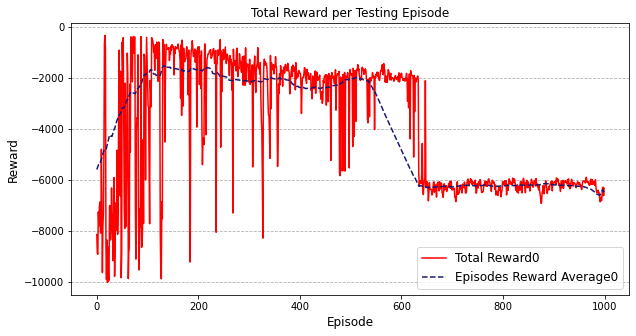

In [33]:
plt.figure(figsize=(10,5))
plt.plot(no_episodes,rewards_0, color = 'red',  linestyle = '-', 
        label = 'Total Reward0')

plt.plot(no_episodes, avg_rewards_0, color = 'midnightblue',  linestyle = '--', 
        label = 'Episodes Reward Average0')


plt.grid(b = True, which = 'major', axis = 'y', linestyle = '--')
plt.xlabel('Episode', fontsize = 12)
plt.ylabel('Reward',  fontsize = 12)
plt.title('Total Reward per Testing Episode',  fontsize = 12)  
plt.legend(loc = 'lower right', fontsize = 12)    
plt.show()

In [25]:
np.mean(rewards_0)+np.mean(rewards_1)+np.mean(rewards_2)

-8887.33046059408

In [26]:
np.mean(rewards_0+rewards_1+rewards_2)

-2962.4434868646927

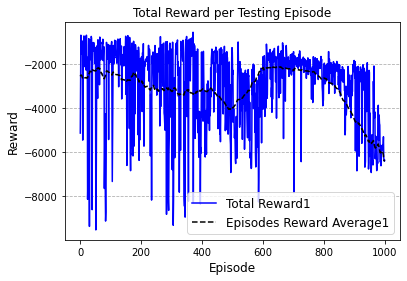

In [27]:
plt.plot(no_episodes,rewards_1, color = 'blue',  linestyle = '-', 
        label = 'Total Reward1')
plt.plot(no_episodes, avg_rewards_1, color = 'black',  linestyle = '--', 
        label = 'Episodes Reward Average1')

plt.grid(b = True, which = 'major', axis = 'y', linestyle = '--')
plt.xlabel('Episode', fontsize = 12)
plt.ylabel('Reward',  fontsize = 12)
plt.title('Total Reward per Testing Episode',  fontsize = 12)  
plt.legend(loc = 'lower right', fontsize = 12)    
plt.show()


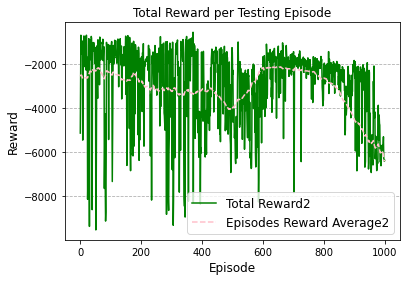

In [28]:
plt.plot(no_episodes,rewards_2, color = 'green',  linestyle = '-', 
        label = 'Total Reward2')
plt.plot(no_episodes, avg_rewards_2, color = 'pink',  linestyle = '--', 
        label = 'Episodes Reward Average2')

plt.grid(b = True, which = 'major', axis = 'y', linestyle = '--')
plt.xlabel('Episode', fontsize = 12)
plt.ylabel('Reward',  fontsize = 12)
plt.title('Total Reward per Testing Episode',  fontsize = 12)  
plt.legend(loc = 'lower right', fontsize = 12)    
plt.show()

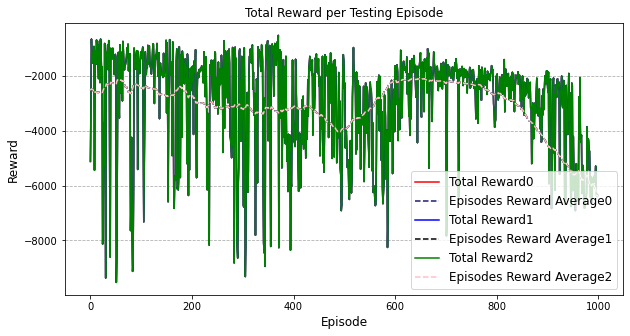

In [29]:
plt.figure(figsize=(10,5))
plt.plot(no_episodes,rewards_0, color = 'red',  linestyle = '-', 
        label = 'Total Reward0')

plt.plot(no_episodes, avg_rewards_0, color = 'midnightblue',  linestyle = '--', 
        label = 'Episodes Reward Average0')

plt.plot(no_episodes,rewards_1, color = 'blue',  linestyle = '-', 
        label = 'Total Reward1')
plt.plot(no_episodes, avg_rewards_1, color = 'black',  linestyle = '--', 
        label = 'Episodes Reward Average1')
plt.plot(no_episodes,rewards_2, color = 'green',  linestyle = '-', 
        label = 'Total Reward2')
plt.plot(no_episodes, avg_rewards_2, color = 'pink',  linestyle = '--', 
        label = 'Episodes Reward Average2')

plt.grid(b = True, which = 'major', axis = 'y', linestyle = '--')
plt.xlabel('Episode', fontsize = 12)
plt.ylabel('Reward',  fontsize = 12)
plt.title('Total Reward per Testing Episode',  fontsize = 12)  
plt.legend(loc = 'lower right', fontsize = 12)    
plt.show()

In [30]:
total_avg_reward=[]

In [31]:
for i in range(0,1000):
    k=np.mean(rewards_0[i]+rewards_1[i]+rewards_2[i])
    k=np.round(k,3)
    total_avg_reward.append(k)

In [32]:
avg_total=[]

In [33]:
for i in range(0,1000):
    k=np.mean(total_avg_reward[i:i+100])
    k=np.round(k,3)
    avg_total.append(k)

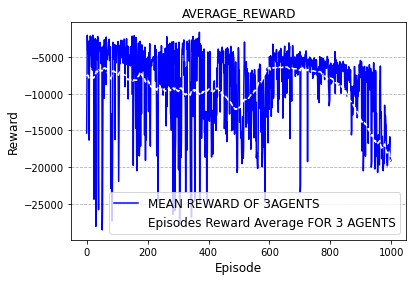

In [34]:
plt.plot(no_episodes,total_avg_reward, color = 'blue',  linestyle = '-', 
        label = 'MEAN REWARD OF 3AGENTS')
plt.plot(no_episodes, avg_total, color = 'white',  linestyle = '--', 
        label = 'Episodes Reward Average FOR 3 AGENTS')

plt.grid(b = True, which = 'major', axis = 'y', linestyle = '--')
plt.xlabel('Episode', fontsize = 12)
plt.ylabel('Reward',  fontsize = 12)
plt.title('AVERAGE_REWARD',fontsize = 12)  
plt.legend(loc = 'lower right', fontsize = 12)    
plt.show()

In [36]:
agent1.actor.save('actor_model.h5')

In [37]:
agent1.critic.save('critic_model.h5')

[<tf.Variable 'dense_6/kernel:0' shape=(21, 16) dtype=float32, numpy=
 array([[-5.09392142e-01,  3.68164897e-01, -3.83832306e-01,
         -9.02906477e-01, -8.71102452e-01, -9.32410061e-01,
         -6.97699562e-02, -1.79780889e+00, -3.88581567e-02,
          6.25839084e-02, -6.39559189e-03, -7.76263356e-01,
         -6.19652450e-01,  4.70268488e-01, -7.15224743e-01,
         -3.10086697e-01],
        [ 6.82862937e-01, -1.14630064e-04, -1.70903906e-01,
         -1.26941785e-01, -1.27869654e+00, -4.06113058e-01,
          2.57350177e-01, -2.36584079e-02,  1.93885922e-01,
         -1.15936112e+00,  2.42937997e-01, -1.42428017e+00,
         -1.18750162e-01, -1.00830650e+00,  9.20019746e-02,
          7.40710020e-01],
        [ 6.74674332e-01,  3.74028385e-01, -2.35173032e-01,
          1.87499393e-02, -3.99986058e-01, -6.18925869e-01,
         -1.74790487e-01, -8.29222202e-02, -1.48670375e-01,
         -1.78368613e-01,  4.87543404e-01, -5.83423115e-02,
          3.06232721e-01, -2.4169232